## Fit A Few Models

In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression #C is regularization param
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import discriminant_analysis
from sklearn import naive_bayes
from ticket_prediction_data import Ticket_PredictionData

tixO = Ticket_PredictionData()

X_train, X_test, y_train, y_test = tixO.get_data()

logistic = LogisticRegression(C=1e5) 

logistic.fit(X_train, y_train)
logistic_proba = logistic.predict_proba(X_train)
preds = logistic_proba[:,1]

Connection working!
Querying for main table
Got main table
Simplifying venues
Venues simplified
Simplifying events
Events simplified
Simplifying zones
Zones simplified
Querying for performers
Dummying performers
Performers dummied
Concatenating dummied performers
Performers concatanated
Starting final cleanup
Done


In [2]:
logistic = LogisticRegression(C=1e5) 

logistic.fit(X_train, y_train)
logistic_proba = logistic.predict_proba(X_train)
preds = logistic_proba[:,1]

In [8]:
predsT = logistic.predict_proba(X_test)[:,1]

## Custom Model Score Definition

In [12]:
def ModelScore(prob_pred, actuals, prob_cut, fn_penalty = 15): #static result

    tn, fp, fn, tp = confusion_matrix(actuals, prob_pred > prob_cut).ravel()
    
    return (fn_penalty*fn + 1*fp) / prob_pred.shape[0]

def rbsLoss(p, q, prob_pred, actuals, fn_penalty = 15): #recursive binary search
    
    eps = (q-p) / 1000
    tol = .0005
    
    if((q-p) < tol):
        return (p, ModelScore(prob_pred, actuals, p, fn_penalty = 15))
    
    m = (p + q) / 2.0
    
    if(ModelScore(prob_pred, actuals, m, fn_penalty = 15) > ModelScore(prob_pred, actuals, m+eps, fn_penalty = 15)):
        return rbsLoss(m,q,prob_pred, actuals, fn_penalty = 15)
    else:
        return rbsLoss(p,m,prob_pred, actuals, fn_penalty = 15)
    
def ModelOpt(preds_train, y_train, preds_test, y_test):
    
    trainingData = rbsLoss(0,1,preds_train, y_train) # (p_train, train_ModelScore)
    testData = (trainingData[0],ModelScore(preds_test, y_test, trainingData[0], fn_penalty = 15)) # (p_train, test_ModelScore)
    
    return (trainingData, testData)

## Test the Above

In [13]:
ModelOpt(preds, y_train, predsT, y_test)

((0.185546875, 0.81577001600176569), (0.185546875, 1.0758525504629364))

## Logistic Custom Loss Scores

In [51]:
x0 = np.linspace(0,1,101)
y0 = np.zeros(101)
i = 0

for each in x0:
    y0[i] = ModelScore(preds, y_train, each)
    i = i+1

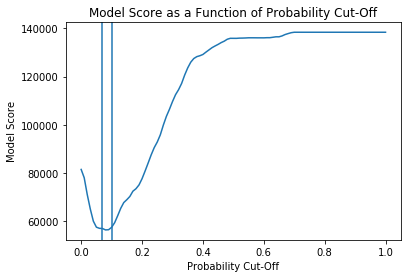

In [52]:
plt.plot(x0, y0)
plt.axvline(x = 0.07)
plt.axvline(x = 0.10)
plt.xlabel('Probability Cut-Off')
plt.ylabel('Model Score')
plt.title('Model Score as a Function of Probability Cut-Off')
plt.show()

## Random Forest Custom Loss Scores

In [5]:
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)
rfc_proba = rfc.predict_proba(X_train)
rfc_preds = rfc_proba[:,1]

In [6]:
x_rfc = np.linspace(0,1,201)
y_rfc = np.zeros(201)
i = 0

for each in x_rfc:
    y_rfc[i] = ModelScore(rfc_preds, y_train, each)
    i = i+1

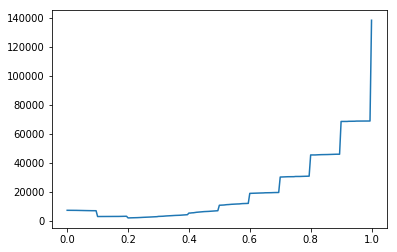

In [7]:
plt.plot(x_rfc, y_rfc)
plt.show()

In [8]:
rfcDF = pd.DataFrame()
rfcDF['CutOff'] = x_rfc
rfcDF['CustomLossScore'] = y_rfc

In [9]:
rfcDF.loc[rfcDF.CustomLossScore == rfcDF.CustomLossScore.min()]

,CutOff,CustomLossScore
40,0.2,1861.0


In [10]:
logDF = pd.DataFrame()
logDF['CutOff'] = x
logDF['CustomLossScore'] = y
logDF.loc[logDF.CustomLossScore == logDF.CustomLossScore.min()]

,CutOff,CustomLossScore
8,0.08,55759.0


## Recursive Binary Search for Minimum

In [60]:
rbsLoss(0,1, preds, y_train, fn_penalty = 15) 

0
1
0
0.5
0
0.25
0
0.125
0.0625
0.125
0.09375
0.125
0.09375
0.109375
0.1015625
0.109375
0.1015625
0.10546875
0.1015625
0.103515625
0.1015625
0.1025390625
0.1015625
0.10205078125
Final predicted cut-off is:  0.1015625


57916

## Zoom on Local Behavior

In [29]:
x = np.linspace(0.07,0.10,301)
y = np.zeros(301)
i = 0

for each in x:
    y[i] = ModelScore(preds, y_train, each)
    i = i+1

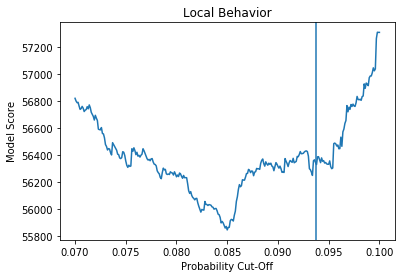

In [61]:
plt.plot(x, y)
plt.xlabel('Probability Cut-Off')
plt.axvline(x = .09375)
plt.ylabel('Model Score')
plt.title('Local Behavior')
plt.show()